<a href="https://colab.research.google.com/github/GergelyTuri/fiberphotometry/blob/main/PCB_serotonin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of PCB fiber photometry data
The code involves using a library from Tucker Davies Tech. (TDT) to read in the data from a fiber photometry experiment. They have a ton of useful descriptiond and tutorials on their website.

[About the data storage and structure](https://www.tdt.com/docs/sdk/offline-data-analysis/tdt-data-storage/)

[Example notebooks](https://www.tdt.com/docs/sdk/offline-data-analysis/offline-data-python/examples/)

GT downloaded two notebooks from that website which shows how to work with the infromation saved in the "epocs" dictionary. The notebooks are located in this same folder. 

This first-pass analysis shoud involve the following steps:
1. Load the data
2. load the timestamped data (`epocs`)
3. Subtract the static signal from the dynamic signal to get rid of motion and other artifacts
4. calculate a (rolling?) average of the signal in the baseline period (between ~3 sec after start and the `bline_end` periods)
5. normalize the signal between `injection` and the end of the signal with the average baseline.
6. Z score the signal
7. plot the Z score signal with the `epocs` data for visualization.
8. Quantifying the signals and comparing saline and drug conditions. TBD.

Author: Anna Treat

Changes:

* 6/28/2024 - setup the notebook

#### installing the necessary packages from Tucker Davis Technologies

In [ ]:
!pip install tdt

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

import tdt
%config Completer.use_jedi = False

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#### Example data path

In [8]:
data_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/jack-240627-105240"

#### Load the data

In [9]:

data = tdt.read_block(data_path)
print(data)
print('===============')
print(data.info)

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/jack-240627-105240/Notes.txt
read from t=0s to t=5400.24s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323'
blockname:	'jack-240627-105240'
start_date:	datetime.datetime(2024, 6, 27, 14, 52, 43, 999999)
utc_start_time:	'14:52:43'
stop_date:	datetime.datetime(2024, 6, 27, 16, 22, 44, 237236)
utc_stop_time:	'16:22:44'
duration:	datetime.timedelta(seconds=5400, microseconds=237237)
stream_channel:	0
snip_channel:	0
experiment:	'drug_experiment'
subject:	'jack'
user:	'User'
start:	'10:52:44am 06/27/2024'
stop:	'12:22:44pm 06/27/2024'


In [10]:
data.streams.keys()

dict_keys(['_405A', '_465A', '_405B', '_465B', 'Fi1d', 'Fi1r'])

The data that we need can be grabbed using the `'_405A'` and `'_465A'` tags. The `'_405A'` tag is the signal from the 405nm laser, and it represents the static signal (Isobestic line), while the `'_465A'` tag is the dynamic signal.

In [11]:
serotonin = '_465A' # serotonin channel
ISOS = '_405A' # Isosbestic channel

#### The other type of data is in the `epocs` field. This is time-stamped information about the experiment. The `epocs` field contains the following information:
`bline_end` => end of the baseline recording

`injection` => time of the injection

`clap`, `clap2`, `clap3` ... => time when the experimener gave a "clap" stimulus. 

In [ ]:
stim_data = pd.DataFrame.from_dict(data.epocs.Note)
stim_data

#### Plotting dynamic and static signals. 
the big spike at the beginning is an artifact and needs to be disrearded. 

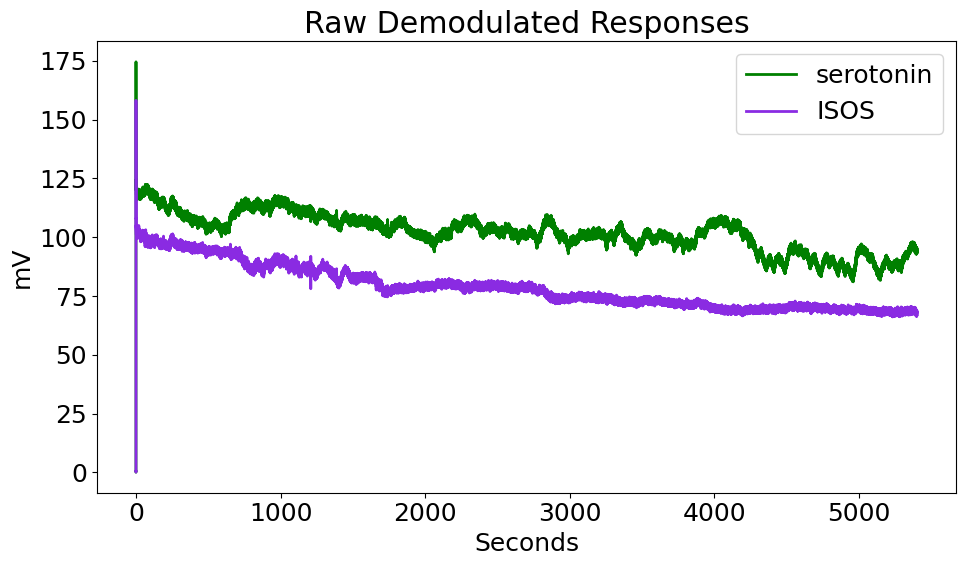

In [ ]:
npts = len(data.streams[serotonin].data)
time_x = np.linspace(1, npts, npts) / data.streams[serotonin].fs
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)
p1, = ax0.plot(time_x, data.streams[serotonin].data, linewidth=2,
               color='green', label='serotonin')
p2, = ax0.plot(time_x, data.streams[ISOS].data, linewidth=2,
               color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()
plt.show()

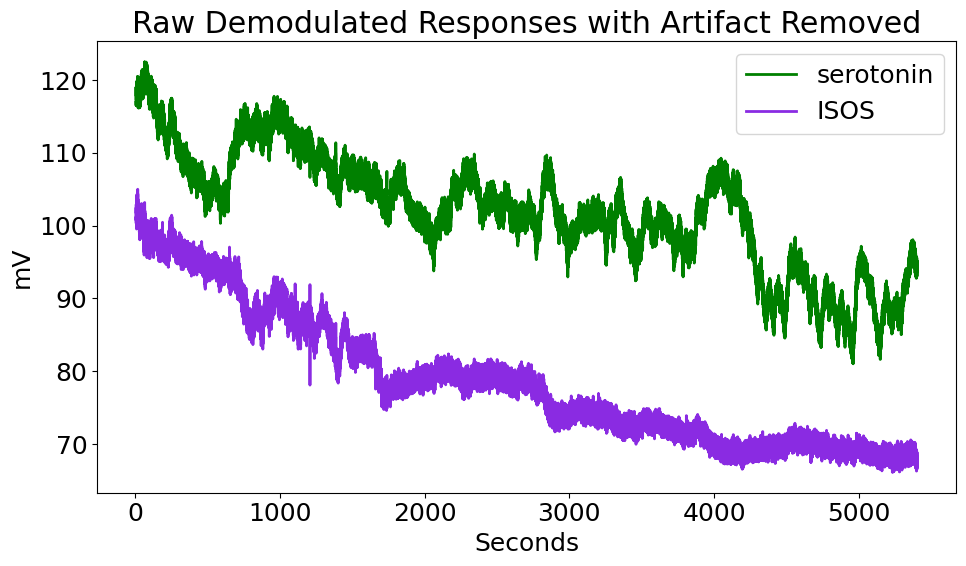

In [ ]:
#plots with artifact removed serotonin

t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:] # go from ind to final index
data.streams[serotonin].data = data.streams[serotonin].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)
p1, = ax1.plot(time_x, data.streams[serotonin].data, linewidth=2,
               color='green', label='serotonin')
p2, = ax1.plot(time_x, data.streams[ISOS].data, linewidth=2,
               color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responses with Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()
plt.show()

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_11-240626-142339/Notes.txt
read from t=0s to t=3719.62s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323'
blockname:	'nia_11-240626-142339'
start_date:	datetime.datetime(2024, 6, 26, 18, 23, 42, 999999)
utc_start_time:	'18:23:42'
stop_date:	datetime.datetime(2024, 6, 26, 19, 25, 42, 621075)
utc_stop_time:	'19:25:42'
duration:	datetime.timedelta(seconds=3719, microseconds=621076)
stream_channel:	0
snip_channel:	0
experiment:	'drug_experiment'
subject:	'nia_11'
user:	'User'
start:	'2:23:43pm 06/26/2024'
stop:	'3:25:43pm 06/26/2024'


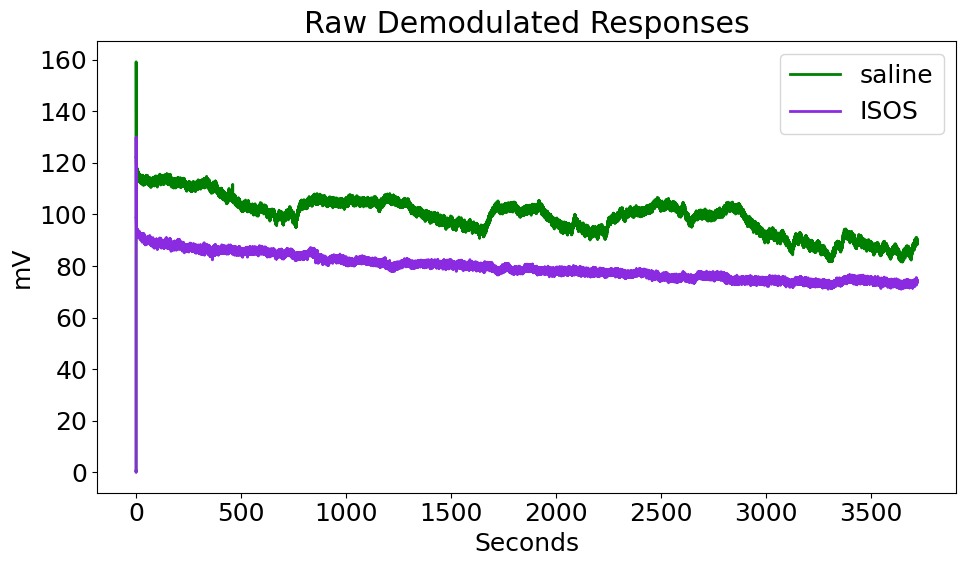

In [ ]:
#plots saline with artifacts removed

control_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_11-240626-142339"

data = read_block(control_path)
print(data)
print('===============')
print(data.info)
saline = '_465A' # saline channel
ISOS = '_405A' # Isosbestic channel
LICK = 'Ler_'

npts = len(data.streams[saline].data)
time_x = np.linspace(1, npts, npts) / data.streams[saline].fs
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)
p1, = ax0.plot(time_x, data.streams[saline].data, linewidth=2, color='green', label='saline')
p2, = ax0.plot(time_x, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()


Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_11-240626-142339/Notes.txt
read from t=0s to t=3719.62s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323'
blockname:	'nia_11-240626-142339'
start_date:	datetime.datetime(2024, 6, 26, 18, 23, 42, 999999)
utc_start_time:	'18:23:42'
stop_date:	datetime.datetime(2024, 6, 26, 19, 25, 42, 621075)
utc_stop_time:	'19:25:42'
duration:	datetime.timedelta(seconds=3719, microseconds=621076)
stream_channel:	0
snip_channel:	0
experiment:	'drug_experiment'
subject:	'nia_11'
user:	'User'
start:	'2:23:43pm 06/26/2024'
stop:	'3:25:43pm 06/26/2024'


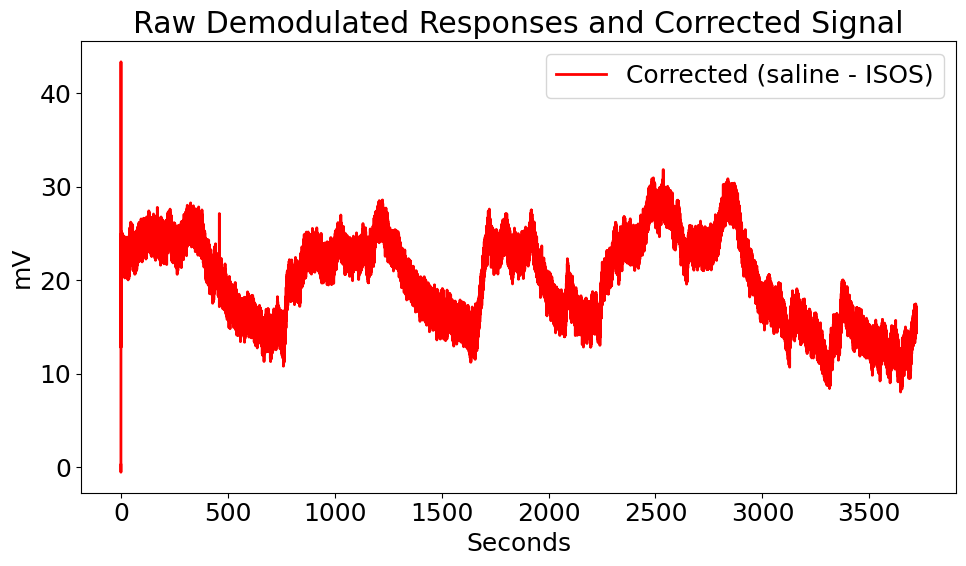

In [ ]:
#plots ISOS signal subtracted from saline signal

control_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_11-240626-142339"


data = read_block(control_path)
print(data)
print('===============')
print(data.info)
saline = '_465A' # saline channel
ISOS = '_405A' # Isosbestic channel
LICK = 'Ler_'

saline = '_465A'  # saline channel
ISOS = '_405A'  # Isosbestic channel

# Prepare the time axis for control data
npts_control = len(data.streams[saline].data)
time_x_control = np.linspace(1, npts_control, npts_control) / data.streams[saline].fs

# Subtract the ISOS signal from the saline signal
corrected_signal = data.streams[saline].data - data.streams[ISOS].data

# Plot the raw demodulated responses and the corrected signal
fig1 = plt.figure(figsize=(10, 6))
ax0 = fig1.add_subplot(111)
p3, = ax0.plot(time_x_control, corrected_signal, linewidth=2, color='red', label='Corrected (saline - ISOS)')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses and Corrected Signal')
ax0.legend(handles=[p3], loc='upper right')
fig1.tight_layout()
plt.show()


Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/jack-240627-105240/Notes.txt
read from t=0s to t=5400.24s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323'
blockname:	'jack-240627-105240'
start_date:	datetime.datetime(2024, 6, 27, 14, 52, 43, 999999)
utc_start_time:	'14:52:43'
stop_date:	datetime.datetime(2024, 6, 27, 16, 22, 44, 237236)
utc_stop_time:	'16:22:44'
duration:	datetime.timedelta(seconds=5400, microseconds=237237)
stream_channel:	0
snip_channel:	0
experiment:	'drug_experiment'
subject:	'jack'
user:	'User'
start:	'10:52:44am 06/27/2024'
stop:	'12:22:44pm 06/27/2024'


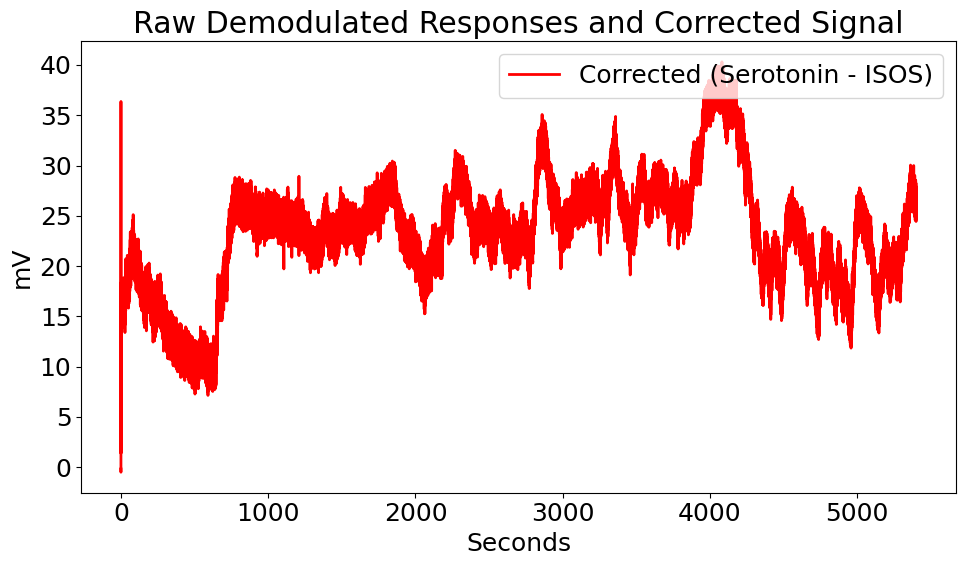

In [ ]:
#plots ISOS signal subtracted from serotonin signal
from re import S
serotonin_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/jack-240627-105240"


data = read_block(serotonin_path)
print(data)
print('===============')
print(data.info)
Serotonin = '_465A' # Serotonin channel
ISOS = '_405A' # Isosbestic channel
LICK = 'Ler_'

Serotonin = '_465A'  # Serotonin channel
ISOS = '_405A'  # Isosbestic channel

# Prepare the time axis for control data
npts_control = len(data.streams[Serotonin].data)
time_x_control = np.linspace(1, npts_control, npts_control) / data.streams[Serotonin].fs

# Subtract the ISOS signal from the Serotonin signal
corrected_signal = data.streams[Serotonin].data - data.streams[ISOS].data

# Plot the raw demodulated responses and the corrected signal
fig1 = plt.figure(figsize=(10, 6))
ax0 = fig1.add_subplot(111)
p3, = ax0.plot(time_x_control, corrected_signal, linewidth=2, color='red', label='Corrected (Serotonin - ISOS)')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses and Corrected Signal')
ax0.legend(handles=[p3], loc='upper right')
fig1.tight_layout()
plt.show()

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_11-240626-142339/Notes.txt
read from t=0s to t=3719.62s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323'
blockname:	'nia_11-240626-142339'
start_date:	datetime.datetime(2024, 6, 26, 18, 23, 42, 999999)
utc_start_time:	'18:23:42'
stop_date:	datetime.datetime(2024, 6, 26, 19, 25, 42, 621075)
utc_stop_time:	'19:25:42'
duration:	datetime.timedelta(seconds=3719, microseconds=621076)
stream_channel:	0
snip_channel:	0
experiment:	'drug_experiment'
subject:	'nia_11'
user:	'User'
start:	'2:23:43pm 06/26/2024'
stop:	'3:25:43pm 06/26/2024'


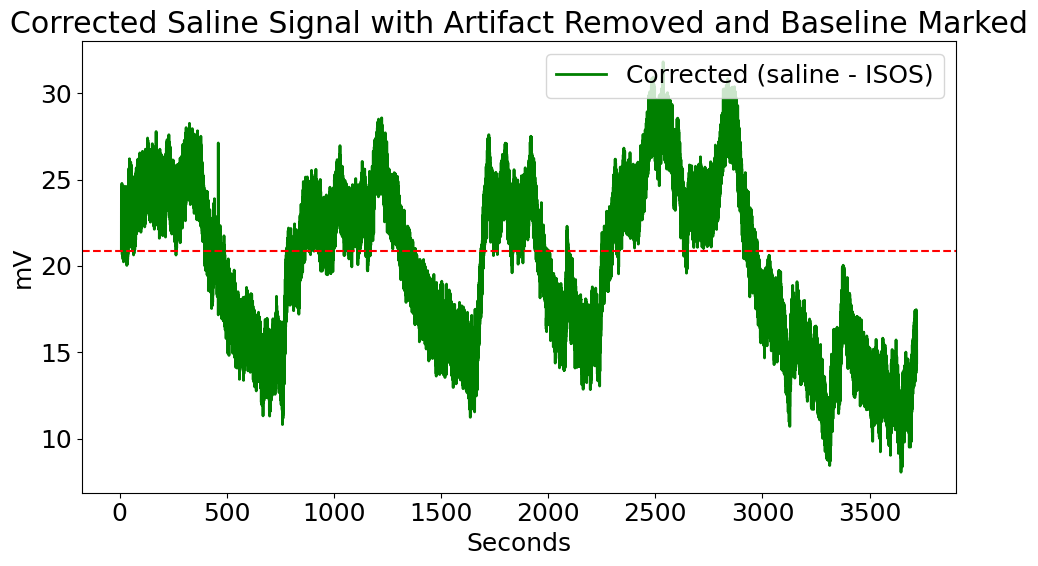

In [12]:
#plots saline signal with ISOS subtracted, artifact removed, and baseline displayed

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tdt import read_block
from datetime import datetime
from scipy.stats import zscore

matplotlib.rcParams['font.size'] = 18  # set font size for all figures

# Path to the control data file
control_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_11-240626-142339"

# Read the data
data = read_block(control_path)
print(data)
print('===============')
print(data.info)

# Define channels
saline = '_465A'  # saline channel
ISOS = '_405A'  # Isosbestic channel

# Prepare the time axis for control data
npts = len(data.streams[saline].data)
time_x = np.linspace(1, npts, npts) / data.streams[saline].fs

# Subtract the ISOS signal from the saline signal
corrected_signal = data.streams[saline].data - data.streams[ISOS].data

# Define experiment start time and baseline end time
start_time_str = '10:52:44am 06/27/2024'
bline_end_str = '11:19:08am 06/27/2024'
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p %m/%d/%Y')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p %m/%d/%Y')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Artifact removal
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:]  # go from ind to final index
corrected_signal = corrected_signal[ind:]

# Plot the corrected saline signal with artifact removed
fig1, ax0 = plt.subplots(figsize=(10, 6))
p1, = ax0.plot(time_x, corrected_signal, linewidth=2, color='green', label='Corrected (saline - ISOS)')

# Mark the baseline end with a horizontal line
baseline_end_idx = np.where(time_x > bline_end_sec - t)[0][0]
baseline_value = np.mean(corrected_signal[:baseline_end_idx])
ax0.axhline(y=baseline_value, color='red', linestyle='--', label='Baseline')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Corrected Saline Signal with Artifact Removed and Baseline Marked')
ax0.legend(handles=[p1], loc='upper right')
fig1.tight_layout()


plt.show()



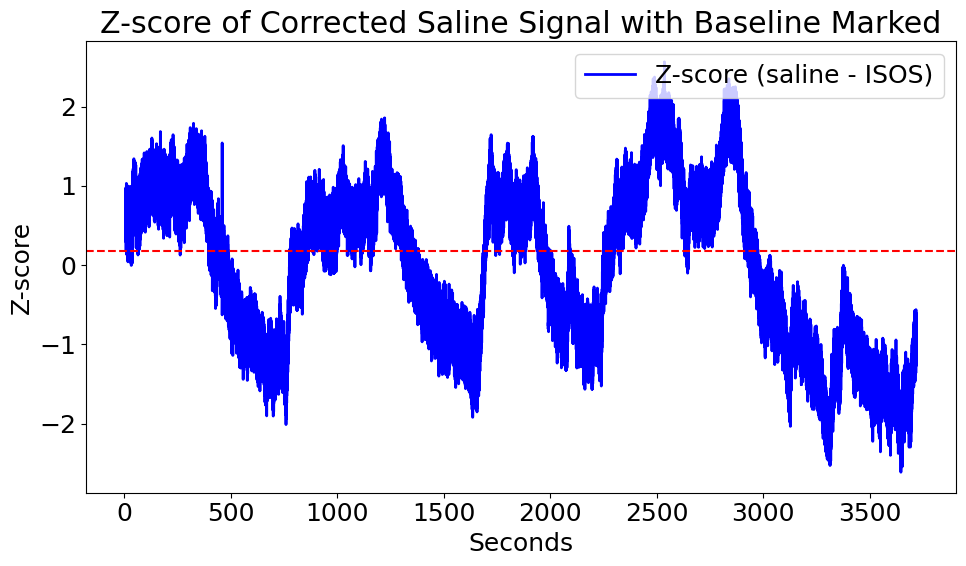

In [14]:
#PLOT Z SCORE OF SALINE


# Calculate the z-score
zscore_signal = zscore(corrected_signal)

# Plot the z-score of the corrected saline signal
fig2, ax1 = plt.subplots(figsize=(10, 6))
p2, = ax1.plot(time_x, zscore_signal, linewidth=2, color='blue', label='Z-score (saline - ISOS)')

# Mark the baseline with a horizontal line on the z-score plot
baseline_zscore = np.mean(zscore_signal[:baseline_end_idx])
ax1.axhline(y=baseline_zscore, color='red', linestyle='--', label='Baseline')

ax1.set_ylabel('Z-score')
ax1.set_xlabel('Seconds')
ax1.set_title('Z-score of Corrected Saline Signal with Baseline Marked')
ax1.legend(handles=[p2], loc='upper right')
fig2.tight_layout()
plt.show()

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/jack-240627-105240/Notes.txt
read from t=0s to t=5400.24s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323'
blockname:	'jack-240627-105240'
start_date:	datetime.datetime(2024, 6, 27, 14, 52, 43, 999999)
utc_start_time:	'14:52:43'
stop_date:	datetime.datetime(2024, 6, 27, 16, 22, 44, 237236)
utc_stop_time:	'16:22:44'
duration:	datetime.timedelta(seconds=5400, microseconds=237237)
stream_channel:	0
snip_channel:	0
experiment:	'drug_experiment'
subject:	'jack'
user:	'User'
start:	'10:52:44am 06/27/2024'
stop:	'12:22:44pm 06/27/2024'


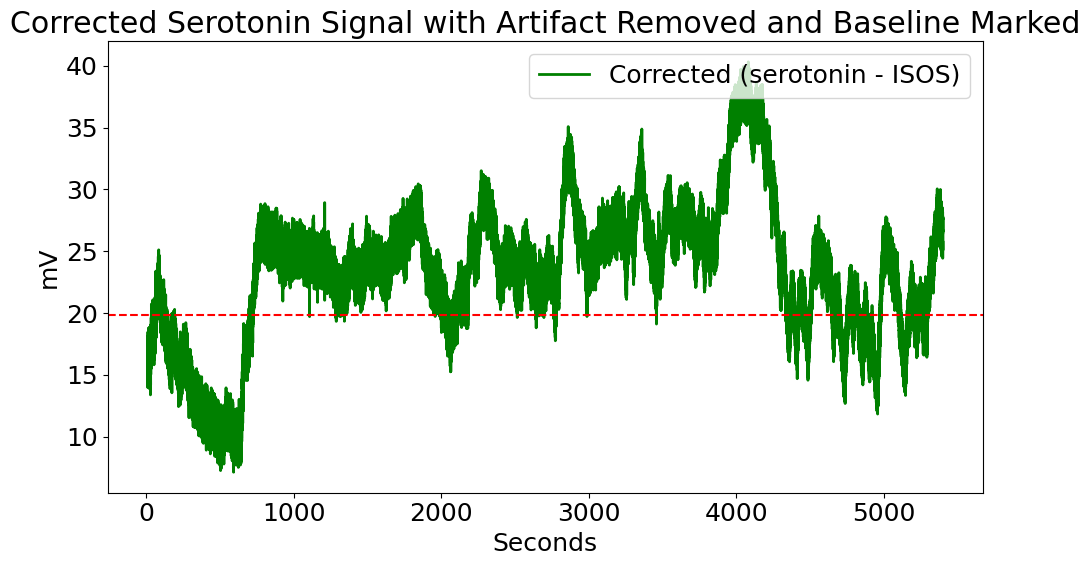

In [16]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tdt import read_block
from datetime import datetime
from scipy.stats import zscore

matplotlib.rcParams['font.size'] = 18  # set font size for all figures

# Path to the serotonin data file
serotonin_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/jack-240627-105240"

# Read the data
data = read_block(serotonin_path)
print(data)
print('===============')
print(data.info)

# Define channels
serotonin = '_465A'  # serotonin channel
ISOS = '_405A'  # Isosbestic channel

# Prepare the time axis for serotonin data
npts = len(data.streams[serotonin].data)
time_x = np.linspace(1, npts, npts) / data.streams[serotonin].fs

# Subtract the ISOS signal from the serotonin signal
corrected_signal = data.streams[serotonin].data - data.streams[ISOS].data

# Define experiment start time and baseline end time
start_time_str = '10:52:44am 06/27/2024'
bline_end_str = '11:19:08am 06/27/2024'
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p %m/%d/%Y')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p %m/%d/%Y')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Artifact removal
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:]  # go from ind to final index
corrected_signal = corrected_signal[ind:]


# Plot the corrected serotonin signal with artifact removed
fig1, ax0 = plt.subplots(figsize=(10, 6))
p1, = ax0.plot(time_x, corrected_signal, linewidth=2, color='green', label='Corrected (serotonin - ISOS)')

# Mark the baseline end with a horizontal line
baseline_end_idx = np.where(time_x > bline_end_sec - t)[0][0]
baseline_value = np.mean(corrected_signal[:baseline_end_idx])
ax0.axhline(y=baseline_value, color='red', linestyle='--', label='Baseline')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Corrected Serotonin Signal with Artifact Removed and Baseline Marked')
ax0.legend(handles=[p1], loc='upper right')
fig1.tight_layout()

plt.show()


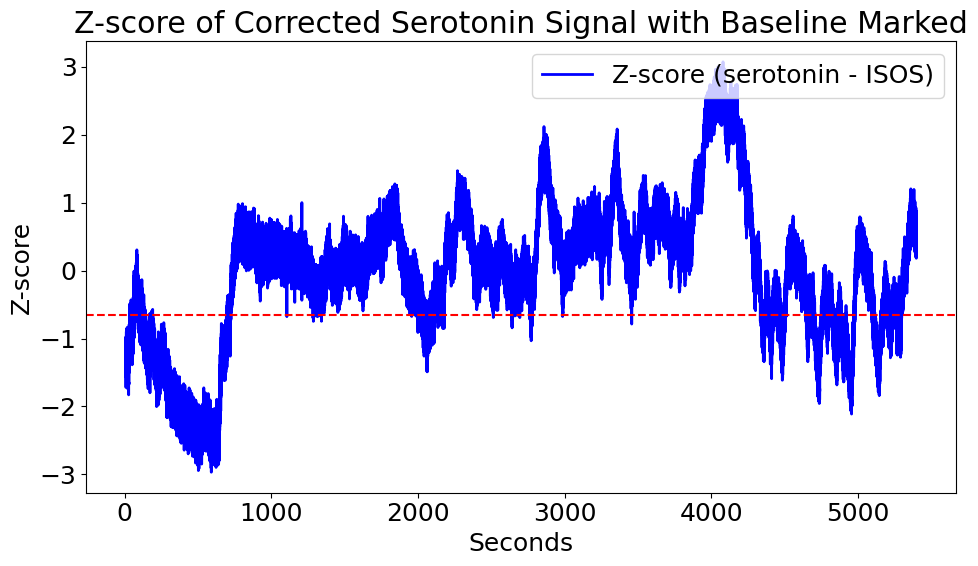

In [17]:
#PLOT Z SCORE OF SEROTONIN

# Calculate the z-score
zscore_signal = zscore(corrected_signal)
# Plot the z-score of the corrected serotonin signal
fig2, ax1 = plt.subplots(figsize=(10, 6))
p2, = ax1.plot(time_x, zscore_signal, linewidth=2, color='blue', label='Z-score (serotonin - ISOS)')

# Mark the baseline with a horizontal line on the z-score plot
baseline_zscore = np.mean(zscore_signal[:baseline_end_idx])
ax1.axhline(y=baseline_zscore, color='red', linestyle='--', label='Baseline')

ax1.set_ylabel('Z-score')
ax1.set_xlabel('Seconds')
ax1.set_title('Z-score of Corrected Serotonin Signal with Baseline Marked')
ax1.legend(handles=[p2], loc='upper right')
fig2.tight_layout()
plt.show()